# Cognitive Services > Vision > Form Recognizer > Layout API

1. Process document with Form Recognizer Layout API
2. Plot bounding boxes for the found data


## To run this notebook
1. Create From Recognizer resource
2. Create 'access_config.json' & provide endpoint & key for the resource (file should be located in the same dir as notebook, else you will need to update config file path)
3. Prepare testing file & update file path to point to this file

In [19]:
# load libraries
import os
import datetime
import json
import pprint

from azure.core.exceptions import ResourceNotFoundError
from azure.ai.formrecognizer import FormRecognizerClient
from azure.core.credentials import AzureKeyCredential

# load API URL & Key from config
config_file = os.path.normpath(os.path.join(os.getcwd(), 'access_config.json'))
with open(config_file, 'r') as j:
     config = json.loads(j.read())

endpoint = config['form.recognizer']['api'] # ex. https://xxxxxxxx.cognitiveservices.azure.com
key = config['form.recognizer']['key'] # ex. 234234werwer23424


In [20]:
def submit_document(filepath):
    """ Submit document for processing"""
    
    result, success = None, False
    
    try:
        # AUTH
        form_recognizer_client = FormRecognizerClient(endpoint, AzureKeyCredential(key))
        
        # load data - example local file
        filepath = os.path.normpath(filepath)
        start_dt = datetime.datetime.now()

        with open(filepath, mode='rb') as file:
            poller = form_recognizer_client.begin_recognize_content(file.read())
        
        # get processing result
        result = poller.result()

        # result returned by Service
        delta = datetime.datetime.now() - start_dt
        print('Time elapsed: %s' %delta)

        print('--RAW DATA-----------------------------------------------')
        print(result)
        print('---------------------------------------------------------')
        success = True 
        
    except Exception as e:
        print('ERROR: image processing, %s' %e)      
        
    return success, result


In [21]:
def process_result(result):
    """ Process result from Layout API: get data from Tables, Lines & Selection Markers
    Params:
        result (list): result returned by prebuilt API
    Returns:
        success (bool): if processing is successfull
        bounding_boxes_tables (list): bounding box coordinates for tables
        bounding_boxes_lines (list): bounding box coordinates for lines
        bounding_boxes_selections (list): bounding box coordinates for selection marks
        data_out (dict): data out grouped by category (table, line, selection)
    """

    # process result
    success = False
    
    bounding_boxes_tables = []
    bounding_boxes_lines = []
    bounding_boxes_selections = []
    
    data_out = {} # data out from tables
    data_out_lines = [] # data out from lines
    data_out_selections = [] # data out from selection markers

    try:
        for page in result:
            data_out[page] = {}
            
            # tables found
            for idx, table in enumerate(page.tables):
                data_out[page][idx] = {}
                print('> Table %s ----------------------' %idx)
                #print(table)
                
                for cell in table.cells:
                    print(cell)
                    print('CELL: [%s, %s] %s' %(cell.row_index, cell.column_index, cell.text))
                    print(cell.bounding_box)
                    bounding_boxes_tables.append(cell.bounding_box) 
                print('- Table End ----------------------------------')
            
            # lines found, where confidence is given for each word found in line
            for idx, line in enumerate(page.lines):
                #print('>> Line %s: %s' %(idx, line))
                bounding_boxes_lines.append(line.bounding_box)
                print('>> Line %s: %s ' %(idx, line.text))
                data_out_lines.append(line.text)
            
            # selection marks found
            for idx, selection in enumerate(page.selection_marks):
                #print('>>> Selection Marker %s: %s' %(idx, selection))
                print('>>> Selection Marker %s (conf %s): %s' %(idx, selection.confidence, selection.state))
                bounding_boxes_selections.append(selection.bounding_box)
                
        print('\n')                
        #pprint.pprint(data_out_lines)
        #pprint.pprint(data_out)
        
        success = True
        
    except Exception as e:
        print('ERROR: data post processing, %s' %e)
    
    return success, bounding_boxes_tables, bounding_boxes_lines, bounding_boxes_selections, data_out

In [22]:
# PROCESS FILE

# receipt example
filepath = os.path.normpath(os.path.join(os.getcwd(), 'BeaconReceipt_Demo.png'))
success, result = submit_document(filepath)


Time elapsed: 0:00:06.319312
--RAW DATA-----------------------------------------------
[FormPage(page_number=1, text_angle=-1.9014, width=927.0, height=1615.0, unit=pixel, tables=[], lines=[FormLine(text=THE BEACON, bounding_box=[Point(x=238.0, y=199.0), Point(x=619.0, y=184.0), Point(x=620.0, y=224.0), Point(x=239.0, y=236.0)], words=[FormWord(text=THE, bounding_box=[Point(x=239.0, y=201.0), Point(x=343.0, y=198.0), Point(x=344.0, y=235.0), Point(x=239.0, y=236.0)], confidence=0.986, page_number=1, kind=word), FormWord(text=BEACON, bounding_box=[Point(x=385.0, y=196.0), Point(x=610.0, y=185.0), Point(x=610.0, y=224.0), Point(x=385.0, y=234.0)], confidence=0.953, page_number=1, kind=word)], page_number=1, kind=line, appearance=TextAppearance(style=TextStyle(name=other, confidence=1.0))), FormLine(text=6 RAFFLES BLVD, MARINA SQUARE, bounding_box=[Point(x=177.0, y=255.0), Point(x=712.0, y=233.0), Point(x=714.0, y=271.0), Point(x=177.0, y=290.0)], words=[FormWord(text=6, bounding_box=[Poi

In [23]:
if success:
    success, bounding_boxes_tables, bounding_boxes_lines, bounding_boxes_selections, data_out = process_result(result)
    print('BB Tables %s' %len(bounding_boxes_tables))
    print('BB Lines %s' %len(bounding_boxes_lines))
    print('BB Selections %s' %len(bounding_boxes_selections))

>> Line 0: THE BEACON 
>> Line 1: 6 RAFFLES BLVD, MARINA SQUARE 
>> Line 2: #01-01/02/03 
>> Line 3: SINGAPORE 039594 
>> Line 4: GST REG NO.201229351M 
>> Line 5: TEL :+65 68831155 FAX:+65 68831551 
>> Line 6: 14/11/2020 
>> Line 7: 19:32 
>> Line 8: ACAI 
>> Line 9: A207000 
>> Line 10: STAFF:KAREN 
>> Line 11: REC:A2 
>> Line 12: -- 
>> Line 13: ---- 
>> Line 14: ----- - 
>> Line 15: ------ 
>> Line 16: 2 GUINNESS DRAUGHT PINT 
>> Line 17: 40.00 
>> Line 18: Disc -50%(1FOR1) 
>> Line 19: -20.00 
>> Line 20: 1 SEAFOOD PASTA 
>> Line 21: 22.40 
>> Line 22: ** SPAGHETTI 
>> Line 23: - - 
>> Line 24: 2 GLS HSE WHITE WINE 
>> Line 25: 28.00 
>> Line 26: Disc -50% (1FOR1) 
>> Line 27: -14.00 
>> Line 28: ------- 
>> Line 29: TOTAL 
>> Line 30: 56.40 
>> Line 31: VISA 
>> Line 32: 56.40 
>> Line 33: Inc.10% Svc Charge 
>> Line 34: 4.79 
>> Line 35: Inc.7% GST 
>> Line 36: 3.69 
>> Line 37: ----- 
>> Line 38: ----- 
>> Line 39: Signature (202011141 21:06:52) 
>>> Selection Marker 0 (conf 0.

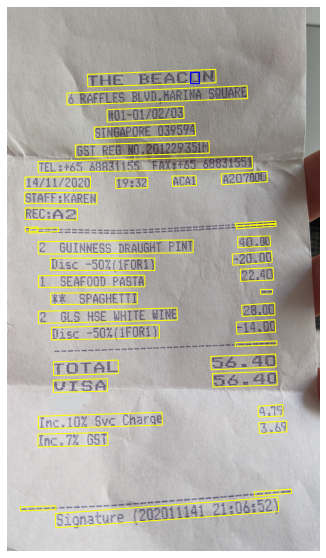

In [24]:
# plot results
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from PIL import Image

%matplotlib inline

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,10))
img = Image.open(filepath)
ax.imshow(img)

# add bounding boxes for the fields found - Tables
for rec in bounding_boxes_tables:
    ax.add_patch(mpatches.Polygon(rec, fill=False, color='magenta'))
    
for rec in bounding_boxes_lines:
    ax.add_patch(mpatches.Polygon(rec, fill=False, color='yellow'))
    
for rec in bounding_boxes_selections:
    ax.add_patch(mpatches.Polygon(rec, fill=False, color='blue'))

plt.axis('off')
plt.show()